# Notebook para manejo de dataframes y generado de informacion a partir de la API de League of Legends.

https://developer.riotgames.com/docs/lol

Autores:  
* Rubén Fernández González (rfgonzalez13@esei.uvigo.es)
* Iván Montes Blanco (imblanco17@esei.uvigo.es)
* Jacobo Cortegoso Budiño (jcbudino17@esei.uvigo.es)
* Rubén Tejo Pereira (rtpereira18@esei.uvigo.es)






El objetivo es generar un Pandas dataframe o varios a partir de los J_SON de la api del LOL. Siendo los dataframes mas importantes lo de los campeones y los de las skills

El resultado final ideal para nuestro recomendador seria un dataframe con Campeones(nombre) como filas y las siguientes columnas: Rol, Lore, Q, W, E, R, Pasiva.

Importamos las librerias de pandas y json.
Necesitamos obtener el nombre de **todos** los campeones automáticamente, por eso usamos Data Dragon, la API de League of Legends, donde tenemos un objeto J_SON con todos los campeones que usaremos como índice para después.

In [114]:
import pandas as pd
import json

df = pd.read_json('http://ddragon.leagueoflegends.com/cdn/10.22.1/data/en_US/champion.json')
df.head()

,type,format,version,data
Aatrox,champion,standAloneComplex,10.22.1,"{'version': '10.22.1', 'id': 'Aatrox', 'key': ..."
Ahri,champion,standAloneComplex,10.22.1,"{'version': '10.22.1', 'id': 'Ahri', 'key': '1..."
Akali,champion,standAloneComplex,10.22.1,"{'version': '10.22.1', 'id': 'Akali', 'key': '..."
Alistar,champion,standAloneComplex,10.22.1,"{'version': '10.22.1', 'id': 'Alistar', 'key':..."
Amumu,champion,standAloneComplex,10.22.1,"{'version': '10.22.1', 'id': 'Amumu', 'key': '..."


Vemos que este DataFrame *df* contiene en su campo data el id de todos los campeones. Lo que hacemos ahora es iterar sobre el id para descargar de la API cada J_SON asociado a cada campeón y concatenarlo en un solo DataFrame.

El J_SON de cada campeón (como ejemplo mostramos a Yasuo) en Data Dragon tiene esta estructura:


In [115]:
EjemploCampeon = pd.read_json('http://ddragon.leagueoflegends.com/cdn/10.22.1/data/en_US/champion/Yasuo.json') 
EjemploCampeon = pd.read_json((EjemploCampeon['data']).to_json(), orient='index')
display(EjemploCampeon)

,id,key,name,title,image,skins,lore,blurb,allytips,enemytips,tags,partype,info,stats,spells,passive,recommended
Yasuo,Yasuo,157,Yasuo,the Unforgiven,"{'full': 'Yasuo.png', 'sprite': 'champion4.png...","[{'id': '157000', 'num': 0, 'name': 'default',...","An Ionian of deep resolve, Yasuo is an agile s...","An Ionian of deep resolve, Yasuo is an agile s...",[Dash through a minion to have Sweeping Blade ...,[Steel Tempest is very narrow. Dodge laterally...,"[Fighter, Assassin]",Flow,"{'attack': 8, 'defense': 4, 'magic': 4, 'diffi...","{'hp': 490, 'hpperlevel': 87, 'mp': 100, 'mppe...","[{'id': 'YasuoQ1Wrapper', 'name': 'Steel Tempe...","{'name': 'Way of the Wanderer', 'description':...","[{'champion': 'Yasuo', 'title': 'Beginner', 'm..."


Vemos que tenemos campos muy interesantes (y muchos otros despreciables) ya accesibles como el nombre y el lore. Sin embargo las descripciones de las skills o la pasiva estan dos niveles más abajo dentro del campo spell.

Bajamos esos niveles:

In [116]:
  s = EjemploCampeon['spells'][0]
  spellsData = [[s[0]['description'], s[1]['description'], s[2]['description'],s[3]['description'],EjemploCampeon['passive'][0]['description']]]
  EjemploHabilidades = pd.DataFrame(spellsData, columns = ['Q' , 'W' , 'E', 'R', 'Passive'], index = ['Yasuo'])
  display(EjemploHabilidades)

,Q,W,E,R,Passive
Yasuo,"Thrusts forward, damaging all enemies in a lin...",Creates a moving wall that blocks all enemy pr...,"Dashes through target enemy, dealing magic dam...",Blinks to an <factionIonia1>Airborne</factionI...,Yasuo's Critical Strike Chance is doubled. Add...


Concatenando el resultado de cada campeón y juntando los dataframes obtendremos el DataFrame *champInfo*. 

Sin embargo para el frontend de nuestra aplicacion necesitamos otros datos. Aprovechando la iteración sobre todos los campeones vamos a sacar un dataframe mas. Este dataframe contendrá el nombre de los campeones, el nombre de sus habilidades (Q,W,E,R, Passive) y la imagen de las mismas (Qimg, Wimg, Wimg, Eimg, Rimg, Passiveimg). Vamos a detallar el proceso con el Ejemplo de Yasuo:
<img src=http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Yasuo_0.jpg>

In [117]:
spellsD = [[s[0]['name'], s[1]['name'], s[2]['name'],s[3]['name'], s[0]['id'], s[1]['id'], s[2]['id'], s[3]['id'], EjemploCampeon['passive'][0]['name'], EjemploCampeon['passive'][0]['image']['full']]]
EjemplofrontSpells = pd.DataFrame(spellsD, columns = ['Q' , 'W' , 'E', 'R', 'Qimg', 'Wimg', 'Eimg', 'Rimg', 'Passive', 'Passiveimg'], index = ['Yasuo'])
EjemplofrontSpells = pd.concat([EjemploCampeon['name'], EjemploCampeon['id'], EjemplofrontSpells], axis=1)
display(EjemplofrontSpells)

,name,id,Q,W,E,R,Qimg,Wimg,Eimg,Rimg,Passive,Passiveimg
Yasuo,Yasuo,Yasuo,Steel Tempest,Wind Wall,Sweeping Blade,Last Breath,YasuoQ1Wrapper,YasuoW,YasuoE,YasuoR,Way of the Wanderer,Yasuo_Passive.png


Ahora tenemos un DataFrame *EjemplofrontSpells* que contiene lo necesario para el frontend para mostrar a Yasuo en nuestra apicación web. Solo añadimos esto en un bucle para completarlo con todos los campeones. 

Las imágenes de los campeones funcionan con las siguientes rutas según su **id**:

(En ese caso el id = Yasuo)

*   Imagen Splash: http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Yasuo_0.jpg
*   Imagen Loading: http://ddragon.leagueoflegends.com/cdn/img/champion/loading/Yasuo_0.jpg
*   Imagen miniatura: http://ddragon.leagueoflegends.com/cdn/10.22.1/img/champion/Yasuo.png

Las imagenes de las habilidades usan **Ximg** y la passiva **Passiveimg**

*   http://ddragon.leagueoflegends.com/cdn/10.22.1/img/spell/YasuoQ1Wrapper.png
*   http://ddragon.leagueoflegends.com/cdn/10.22.1/img/passive/Yasuo_Passive.png





Ahora solo queda generar los dos DataFrames completos con todos los campeones. Recordemos que teníamos el DataFrame *df* que básicamente contiene el 'id' de todos ellos. Iterando sobre el mismo podemos acceder a cada DataDragon de campeón y extraer la información que deseamos. El resultado debería ser *champInfo* para nuestro recomendador y *frontInfo* para el front end de nuestra aplicación.

In [118]:
champInfo = pd.DataFrame() 
frontInfo = pd.DataFrame()

for i in df['data']:
  #pasar json campeones a dataframe
  leeJson = pd.read_json('http://ddragon.leagueoflegends.com/cdn/10.22.1/data/en_US/champion/'+i['id']+'.json')
  datosChamp = pd.read_json((leeJson['data']).to_json(), orient='index')
  
  #pasar json spells y passive a dataframe
  s = datosChamp['spells'][0]
  
  #champInfo
  spellsData = [[s[0]['description'], s[1]['description'], s[2]['description'],s[3]['description'],datosChamp['passive'][0]['description']]]
  spells = pd.DataFrame(spellsData, columns = ['Q', 'W' , 'E', 'R', 'Passive'], index = [i['id']])

  #juntar dataframes y añadir a resultado
  toappend = pd.concat([datosChamp, spells], axis=1)
  champInfo = champInfo.append(toappend)

  #frontInfo
  spellsD = [[s[0]['name'], s[1]['name'], s[2]['name'],s[3]['name'], s[0]['id'], s[1]['id'], s[2]['id'], s[3]['id'], datosChamp['passive'][0]['name'], datosChamp['passive'][0]['image']['full']]]
  front = pd.DataFrame(spellsD, columns = ['Q' , 'W' , 'E', 'R', 'Qimg', 'Wimg', 'Eimg', 'Rimg', 'Passive', 'Passiveimg'], index = [i['id']])
  
  front = pd.concat([datosChamp['name'], datosChamp['id'], front], axis=1)
  frontInfo = frontInfo.append(front)
#end of loop

In [119]:
frontInfo.head()

,name,id,Q,W,E,R,Qimg,Wimg,Eimg,Rimg,Passive,Passiveimg
Aatrox,Aatrox,Aatrox,The Darkin Blade,Infernal Chains,Umbral Dash,World Ender,AatroxQ,AatroxW,AatroxE,AatroxR,Deathbringer Stance,Aatrox_Passive.png
Ahri,Ahri,Ahri,Orb of Deception,Fox-Fire,Charm,Spirit Rush,AhriOrbofDeception,AhriFoxFire,AhriSeduce,AhriTumble,Essence Theft,Ahri_SoulEater2.png
Akali,Akali,Akali,Five Point Strike,Twilight Shroud,Shuriken Flip,Perfect Execution,AkaliQ,AkaliW,AkaliE,AkaliR,Assassin's Mark,Akali_P.png
Alistar,Alistar,Alistar,Pulverize,Headbutt,Trample,Unbreakable Will,Pulverize,Headbutt,AlistarE,FerociousHowl,Triumphant Roar,Alistar_E.png
Amumu,Amumu,Amumu,Bandage Toss,Despair,Tantrum,Curse of the Sad Mummy,BandageToss,AuraofDespair,Tantrum,CurseoftheSadMummy,Cursed Touch,Amumu_Passive.png


In [120]:
champInfo.head()

,id,key,name,title,image,skins,lore,blurb,allytips,enemytips,tags,partype,info,stats,spells,passive,recommended,Q,W,E,R,Passive
Aatrox,Aatrox,266,Aatrox,the Darkin Blade,"{'full': 'Aatrox.png', 'sprite': 'champion0.pn...","[{'id': '266000', 'num': 0, 'name': 'default',...",Once honored defenders of Shurima against the ...,Once honored defenders of Shurima against the ...,[Use Umbral Dash while casting The Darkin Blad...,"[Aatrox's attacks are very telegraphed, so use...","[Fighter, Tank]",Blood Well,"{'attack': 8, 'defense': 4, 'magic': 3, 'diffi...","{'hp': 580, 'hpperlevel': 90, 'mp': 0, 'mpperl...","[{'id': 'AatroxQ', 'name': 'The Darkin Blade',...","{'name': 'Deathbringer Stance', 'description':...","[{'champion': 'Aatrox', 'title': 'AatroxARAM',...","Aatrox slams his greatsword down, dealing phys...","Aatrox smashes the ground, dealing damage to t...","Passively, Aatrox heals when damaging enemy ch...","Aatrox unleashes his demonic form, fearing nea...","Periodically, Aatrox's next basic attack deals..."
Ahri,Ahri,103,Ahri,the Nine-Tailed Fox,"{'full': 'Ahri.png', 'sprite': 'champion0.png'...","[{'id': '103000', 'num': 0, 'name': 'default',...",Innately connected to the latent power of Rune...,Innately connected to the latent power of Rune...,"[Use Charm to set up your combos, it will make...",[Ahri's survivability is dramatically reduced ...,"[Mage, Assassin]",Mana,"{'attack': 3, 'defense': 4, 'magic': 8, 'diffi...","{'hp': 526, 'hpperlevel': 92, 'mp': 418, 'mppe...","[{'id': 'AhriOrbofDeception', 'name': 'Orb of ...","{'name': 'Essence Theft', 'description': 'When...","[{'champion': 'Ahri', 'title': 'AhriARAM', 'ma...","Ahri sends out and pulls back her orb, dealing...",Ahri gains a brief burst of movement speed and...,Ahri blows a kiss that damages and charms an e...,"Ahri dashes forward and fires essence bolts, d...",When Ahri strikes 9 enemies with her abilities...
Akali,Akali,84,Akali,the Rogue Assassin,"{'full': 'Akali.png', 'sprite': 'champion0.png...","[{'id': '84000', 'num': 0, 'name': 'default', ...",Abandoning the Kinkou Order and her title of t...,Abandoning the Kinkou Order and her title of t...,[Akali excels at killing fragile champions. Le...,[Akali can still be hit by area effect spells ...,[Assassin],Energy,"{'attack': 5, 'defense': 3, 'magic': 8, 'diffi...","{'hp': 575, 'hpperlevel': 95, 'mp': 200, 'mppe...","[{'id': 'AkaliQ', 'name': 'Five Point Strike',...","{'name': 'Assassin's Mark', 'description': 'De...","[{'champion': 'Akali', 'title': 'AkaliARAM', '...","Akali throws out five kunai, dealing damage ba...",Akali drops a cover of smoke and briefly gains...,"Flip backward and fire a shuriken forward, dea...","Akali leaps in a direction, damaging enemies s...",Dealing spell damage to a champion creates a r...
Alistar,Alistar,12,Alistar,the Minotaur,"{'full': 'Alistar.png', 'sprite': 'champion0.p...","[{'id': '12000', 'num': 0, 'name': 'default', ...",Always a mighty warrior with a fearsome reputa...,Always a mighty warrior with a fearsome reputa...,[Using Pulverize can allow you to establish be...,[Alistar is very disruptive but very tough - t...,"[Tank, Support]",Mana,"{'attack': 6, 'defense': 9, 'magic': 5, 'diffi...","{'hp': 600, 'hpperlevel': 106, 'mp': 350, 'mpp...","[{'id': 'Pulverize', 'name': 'Pulverize', 'des...","{'name': 'Triumphant Roar', 'description': 'Al...","[{'champion': 'Alistar', 'title': 'AlistarARAM...","Alistar smashes the ground, dealing damage to ...","Alistar rams a target with his head, dealing d...","Alistar tramples nearby enemy units, ignoring ...","Alistar lets out a wild roar, removing all cro...",Alistar charges his roar by stunning or displa...
Amumu,Amumu,32,Amumu,the Sad Mummy,"{'full': 'Amumu.png', 'sprite': 'champion0.png...","[{'id': '32000', 'num': 0, 'name': 'default', ...",Legend claims that Amumu is a lonely and melan...,Legend claims that Amumu is a lonely and melan...,"[Amumu is highly dependent on teammates, so tr...",[Avoid bunching up with other allies w

Tenemos los dos DataFrames listos aunque *champInfo* contiene demasiados campos que para nuestro reconmendador son totalmente innecesarios, asi que los eliminamos:

In [121]:
del champInfo['skins']
del champInfo['key']
del champInfo['id']
del champInfo['blurb']
del champInfo['title']
del champInfo['allytips']
del champInfo['enemytips']
del champInfo['info']
del champInfo['recommended']
del champInfo['spells']
del champInfo['passive']
del champInfo['stats']
del champInfo['image']

champInfo.head()

,name,lore,tags,partype,Q,W,E,R,Passive
Aatrox,Aatrox,Once honored defenders of Shurima against the ...,"[Fighter, Tank]",Blood Well,"Aatrox slams his greatsword down, dealing phys...","Aatrox smashes the ground, dealing damage to t...","Passively, Aatrox heals when damaging enemy ch...","Aatrox unleashes his demonic form, fearing nea...","Periodically, Aatrox's next basic attack deals..."
Ahri,Ahri,Innately connected to the latent power of Rune...,"[Mage, Assassin]",Mana,"Ahri sends out and pulls back her orb, dealing...",Ahri gains a brief burst of movement speed and...,Ahri blows a kiss that damages and charms an e...,"Ahri dashes forward and fires essence bolts, d...",When Ahri strikes 9 enemies with her abilities...
Akali,Akali,Abandoning the Kinkou Order and her title of t...,[Assassin],Energy,"Akali throws out five kunai, dealing damage ba...",Akali drops a cover of smoke and briefly gains...,"Flip backward and fire a shuriken forward, dea...","Akali leaps in a direction, damaging enemies s...",Dealing spell damage to a champion creates a r...
Alistar,Alistar,Always a mighty warrior with a fearsome reputa...,"[Tank, Support]",Mana,"Alistar smashes the ground, dealing damage to ...","Alistar rams a target with his head, dealing d...","Alistar tramples nearby enemy units, ignoring ...","Alistar lets out a wild roar, removing all cro...",Alistar charges his roar by stunning or displa...
Amumu,Amumu,Legend claims that Amumu is a lonely and melan...,"[Tank, Mage]",Mana,"Amumu tosses a sticky bandage at a target, stu...","Overcome by anguish, nearby enemies lose a per...",Permanently reduces the physical damage Amumu ...,Amumu entangles surrounding enemy units in ban...,Amumu's basic attacks <font color='#9b0f5f'>Cu...


**NOTA**: Para seleccionar un dato del cualquier DataFrame usaremos DataFrame.at[fila,columna].

In [122]:
print(frontInfo.at[ 'Yasuo' , 'Q' ])

Steel Tempest


# Recomendador
Necesitamos un Dataframe con nombre, todas las skills concatenadas y el lore (que ya teníamos).

In [123]:
#sacar textos preprocesados de las habilidades y lore para sistema de recomendacion


#importar librerias
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

#procesar texto habilidades para cada campeon
ps = PorterStemmer()
bags = pd.DataFrame(columns=['name','skill','lore'])

for i in frontInfo["id"]:
    stops = set(stopwords.words("english"))
    #extraer y procesar informacion sobre skills
    habil = word_tokenize(champInfo.at[i,'Q']+champInfo.at[i,'W']+champInfo.at[i,'E']+champInfo.at[i,'R'])
    habil = [ps.stem(w) for w in habil if not w in stops and w.isalnum()]
    habil = " ".join(habil)
    #extraer y procesar informacion sobre lore
    lore = word_tokenize(champInfo.at[i,'lore'])
    lore = [ps.stem(w) for w in lore if not w in stops and w.isalnum()]
    lore = " ".join(lore)
    #juntar y añadir a dataframe
    bags = bags.append({'name':champInfo.at[i,'name'],'skill':habil,'lore':lore},ignore_index=True)

display(bags)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,name,skill,lore
0,Aatrox,aatrox slam greatsword deal physic damag He sw...,onc honor defend shurima void aatrox brethren ...
1,Ahri,ahri send pull back orb deal magic damag way t...,innat connect latent power runeterra ahri vast...
2,Akali,akali throw five kunai deal damag base bonu at...,abandon kinkou order titl fist shadow akali st...
3,Alistar,alistar smash ground deal damag nearbi enemi t...,alway mighti warrior fearsom reput alistar see...
4,Amumu,amumu toss sticki bandag target stun damag tar...,legend claim amumu lone melancholi soul ancien...
...,...,...,...
147,Zed,zed shadow throw br br each shuriken deal dama...,utterli ruthless without merci zed leader orde...
148,Ziggs,zigg throw bounc bomb deal magic fling explos ...,with love big bomb short fuse yordl zigg explo...
149,Zilean,toss bomb target area stick unit come near pri...,onc power icathian mage zilean becam obsess pa...
150,Zoe,zoe fire missil redirect flight deal damag lon...,As embodi mischief imagin chang zoe act cosmic...


Aplicar *bag of words* a los dos campos y generear los vectores para el recomendados

In [124]:
#pasar dataframe texto preprocesado a bag of words y añadir a dataframe
from sklearn.feature_extraction.text import TfidfVectorizer
bagOfWordsModel = TfidfVectorizer()
vect_bag_skills = []
vect_bag_lore = []

#bag of words de skills y lore
bagOfWordsModel.fit(bags['skill'])
bag_skills = bagOfWordsModel.transform(bags['skill'])

#bag of words de lore
bagOfWordsModel = TfidfVectorizer()
bagOfWordsModel.fit(bags['lore'])
bag_lore = bagOfWordsModel.transform(bags['lore'])

#generar vectores con los bags de skill y lore
for i in bag_skills:
  vect_bag_skills.append(i)
for i in bag_lore:
  vect_bag_lore.append(i)

#añadir vectores como columna al dataframe
bags['bag_skill'] = vect_bag_skills
bags['bag_lore'] = vect_bag_lore
display(bags)

,name,skill,lore,bag_skill,bag_lore
0,Aatrox,aatrox slam greatsword deal physic damag He sw...,onc honor defend shurima void aatrox brethren ...,"(0, 1357)\t0.11745865911977424\n (0, 1307)\...","(0, 2466)\t0.11957558735673952\n (0, 2439)\..."
1,Ahri,ahri send pull back orb deal magic damag way t...,innat connect latent power runeterra ahri vast...,"(0, 1407)\t0.3091455263021661\n (0, 1399)\t...","(0, 2349)\t0.17465849933115274\n (0, 2214)\..."
2,Akali,akali throw five kunai deal damag base bonu at...,abandon kinkou order titl fist shadow akali st...,"(0, 1415)\t0.11049841026935704\n (0, 1368)\...","(0, 2416)\t0.12447302451809314\n (0, 2194)\..."
3,Alistar,alistar smash ground deal damag nearbi enemi t...,alway mighti warrior fearsom reput alistar see...,"(0, 1422)\t0.18820759156730632\n (0, 1356)\...","(0, 2416)\t0.13582511527225036\n (0, 2406)\..."
4,Amumu,amumu toss sticki bandag target stun damag tar...,legend claim amumu lone melancholi soul ancien...,"(0, 1435)\t0.13829057594843785\n (0, 1357)\...","(0, 2468)\t0.1677688047071753\n (0, 2462)\t..."
...,...,...,...,...,...
147,Zed,zed shadow throw br br each shuriken deal dama...,utterli ruthless without merci zed leader orde...,"(0, 1452)\t0.5923182988051594\n (0, 1413)\t...","(0, 2498)\t0.3577721694045413\n (0, 2456)\t..."
148,Ziggs,zigg throw bounc bomb deal magic fling explos ...,with love big bomb short fuse yordl zigg explo...,"(0, 1456)\t0.1017313074683368\n (0, 1454)\t...","(0, 2502)\t0.34248585930095526\n (0, 2495)\..."
149,Zilean,toss bomb target area stick unit come near pri...,onc power icathian mage zilean becam obsess pa...,"(0, 1356)\t0.1523508693422858\n (0, 1316)\t...","(0, 2503)\t0.3160530927279859\n (0, 2452)\t..."
150,Zoe,zoe fire missil redirect flight deal damag lon...,As embodi mischief imagin chang zoe act cosmic...,"(0, 1455)\t0.20019837449093777\n (0, 1413)\...","(0, 2504)\t0.4177284028921276\n (0, 2462)\t..."


Recomendador, usamos distancias coseno para las skills y euclídeas para el lore. A base de prueba y error son con las que mejores resultados obtuvimos.

In [125]:
#obtener campeones similares dado un nombre
from sklearn.metrics import pairwise_distances

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def recomendar(nombre):
  #obtener posicion del campeon buscado
  pos = -1;
  for i in bags.index:
    if (bags.at[i,'name']==nombre):
      pos = i;
      break;
  
  #generar vectores con distancias
  vect_skill = []
  vect_lore = []
  for i in bags.index:
    #calcular distancias de vectores
    vect_skill.append(pairwise_distances(bags.at[i,'bag_skill'],bags.at[pos,'bag_skill'],metric='cosine')[0][0])
    vect_lore.append(pairwise_distances(bags.at[i,'bag_lore'],bags.at[pos,'bag_lore'],metric='euclidean')[0][0])

  #vector similaridad habilidades
  distance_scores = list(enumerate(vect_skill))
  ordered_scores = sorted(distance_scores, key=lambda x: x[1])
  skills_sim = ordered_scores[1:6]

  #vector similaridad lore
  distance_scores = list(enumerate(vect_lore))
  ordered_scores = sorted(distance_scores, key=lambda x: x[1])
  lore_sim = ordered_scores[1:6]

  #mostrar campeones similares segun skill
  print("> Segun skills: ")
  count = 0;
  lista_skills = []
  for i in skills_sim:
    count += 1;
    name = bags.at[i[0],'name'];
    print(str(count) + " : " + name)
    lista_skills.append(name)
    #display(champInfo.iloc[ i[0] , : ])
  
  #mostrar campeones similares segun lore
  print("> Segun lore: ")
  count = 0;
  lista_lore = []
  for i in lore_sim:
    count += 1;
    name = bags.at[i[0],'name'];
    print(str(count) + " : " + name)
    lista_lore.append(name)
    #display(champInfo.iloc[ i[0] , : ])
  print("Interseccion:")
  print(intersection(lista_lore, lista_skills))

  


recomendar('Sona')

> Segun skills: 
1 : Nami
2 : Lulu
3 : Taric
4 : Seraphine
5 : Rakan
> Segun lore: 
1 : Galio
2 : Fizz
3 : Akali
4 : Rakan
5 : Vayne
Interseccion:
['Rakan']


##Recomendador por imagenes

Las imágenes de los campeones funcionan con las siguientes rutas según su **id**:

(En ese caso el id = Yasuo)

*   Imagen Splash: http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Yasuo_0.jpg
*   Imagen Loading: http://ddragon.leagueoflegends.com/cdn/img/champion/loading/Yasuo_0.jpg
*   Imagen miniatura: http://ddragon.leagueoflegends.com/cdn/10.22.1/img/champion/Yasuo.png

In [126]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [127]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [128]:
# parameters setup (Aqui hay que modificar cosas)

imgs_model_width, imgs_model_height = 224, 224#725, 428#

nb_closest_images = 3 # number of most similar images to retrieve

files = []
for champ in frontInfo['id']:
  #Haria falta un doble bucle para las distintas skins, pero no todos tienen las mismas
  files.append('http://ddragon.leagueoflegends.com/cdn/img/champion/splash/'+champ+'_0.jpg')
  #files.append('http://ddragon.leagueoflegends.com/cdn/img/champion/loading/'+champ+'_0.jpg')
  #files.append('http://ddragon.leagueoflegends.com/cdn/10.22.1/img/champion/'+champ+'.png')

print("number of images:",len(files))
print(files)

number of images: 152
['http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Aatrox_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Ahri_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Akali_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Alistar_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Amumu_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Anivia_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Annie_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Aphelios_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Ashe_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/AurelionSol_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Azir_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Bard_0.jpg', 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Blitzcrank_0.jpg', '

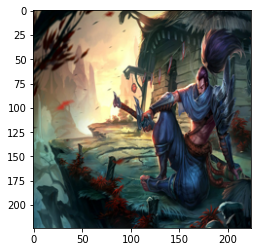

http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Yasuo_0.jpg


In [129]:
# load an image in PIL format
from io import BytesIO
from urllib.request import urlopen

champ0 = 'Yasuo'
#Función para cargar la imagen desde una URL
def loadImage(URL):
    with urlopen(URL) as url:
        img = Image.open(BytesIO(url.read()))
        img = img.resize((224,224))
    return img
def loadImageURL(URL):
  with urlopen(URL) as url:
        img = Image.open(BytesIO(url.read()))
  return img

original = loadImage('http://ddragon.leagueoflegends.com/cdn/img/champion/splash/'+champ0+'_0.jpg')
plt.imshow(original)
plt.show()

print('http://ddragon.leagueoflegends.com/cdn/img/champion/splash/'+champ0+'_0.jpg')


In [130]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [131]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

features successfully extracted!
number of image features: 4096


array([[2.5879002 , 0.        , 0.40079477, ..., 0.        , 0.        ,
        2.0405667 ]], dtype=float32)

In [132]:
#Guardar todas las imagenes en un array

importedImages = []

for f in files:
    original = loadImage(f)
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [133]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(152, 4096)

In [134]:
# compute cosine similarities between images
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
# len(cos_similarities_df.columns)
cos_similarities_df.head()

,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Aatrox_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Ahri_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Akali_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Alistar_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Amumu_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Anivia_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Annie_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Aphelios_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Ashe_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/AurelionSol_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Azir_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Bard_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Blitzcrank_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Brand_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Braum_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Caitlyn_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Camille_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Cassiopeia_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Chogath_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Corki_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Darius_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Diana_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/DrMundo_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Draven_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Ekko_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Elise_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Evelynn_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Ezreal_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Fiddlesticks_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Fiora_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Fizz_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Galio_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Gangplank_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Garen_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Gnar_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Gragas_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Graves_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Hecarim_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Heimerdinger_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Illaoi_0.jpg,...,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Sona_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Soraka_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Swain_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Sylas_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Syndra_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/TahmKench_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Taliyah_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Talon_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Taric_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Teemo_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Thresh_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Tristana_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Trundle_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/Tryndamere_0.jpg,http://ddragon.leagueoflegends.com/cdn/img/champion/splash/TwistedFate_0.jpg,http://ddragon

In [135]:
# function to retrieve the most similar products for a given one

def RecomendadorGrafico(champ):
    given_img = 'http://ddragon.leagueoflegends.com/cdn/img/champion/splash/'+champ+'_0.jpg'
    plt.title("Original product",color='b')
    original = loadImage(given_img)
    show = loadImageURL(given_img)
    #plt.imshow(show)
    #plt.show()

    #print("-----------------------------------------------------------------------")
    #print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = loadImage(closest_imgs[i])
        show = loadImageURL(closest_imgs[i])
        plt.title("similarity score :"+str(closest_imgs_scores[i]), color='b')
        plt.imshow(show)
        plt.show()

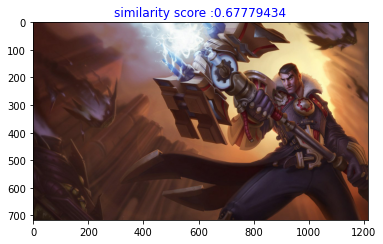

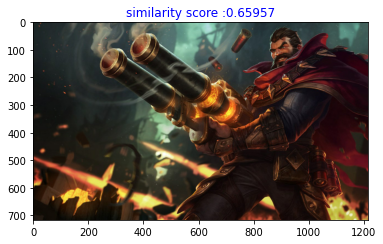

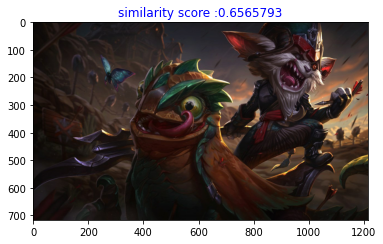

In [136]:
RecomendadorGrafico('Yasuo')

# Valorador

Recoger tweets recientes de un campeon, por ejemplo Yasuo.

In [137]:
import os
import tweepy as tw
import pandas as pd
from datetime import datetime, timedelta


d = datetime.today() - timedelta(days=30)

date_time = d.strftime("%Y-%m-%d")


num = 0
Losdatos = pd.read_csv('TweetsValorados.csv')
del Losdatos[Losdatos.columns[0]]

consumer_key= 'KatBRlOrrS5Ocj1spbU4kY3Nf'
consumer_secret= 'GLcJQOSrNi2btYSu8UUqaVVpKcxLnMdjB9ffkU0LtauxPpjOoL'
access_token= '1337738322945462272-nR5TSl5hGrTojizeznHRLOOAuKb20t'
access_token_secret= 'F4qVZ7icDX6Gpiqa7Z1DSIXUuAdvbTXCXqMVfooEL2WTP'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

def BuscarTweets(nombre,date):
  search_words = nombre + " -filter:retweets" + "League"
  date_since = date

  tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(250)

  tuits = [tweet.text for tweet in tweets]
  if len(tuits) < 50:
      search_words = nombre + " -filter:retweets"
      tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(250)
      newtuits = [tweet.text for tweet in tweets]      
      tuits = tuits.extend(newtuits)
  tweet_text = pd.DataFrame(data=tuits,columns=['tweet'])
  return tuits
tuits = BuscarTweets("Yasuo",date_time)
display(tuits)

['RT @NoniRosee: ,, I remember drawing this for a dearie @/punbun_4fun half a millennia ago,, but was too shy to finish/post it snnssjssjskkk…',
 'RT @MelaninEdenian: if you main yasuo or yone in league i automatically assume that you have mental disabilities https://t.co/F5sm0P1k4Y',
 'RT @Punbun_4Fun: felt like drawing smth simple rn\n\n#yasuo #yone #ArtofLegends https://t.co/gTXMNRjR4W',
 '@RiotFeralPony @MATEO73380325 Can we suggest some type of new skin design for yasuo? Maybe another one with a  hat?… https://t.co/WRxZe5XJns',
 "RT @Symphonicpyro: Here's my submission for the #LeagueofLegends 2021 Fanart contest &lt;:\n\n#Yone #Yasuo #SpiritBlossom #TheEmpyrean #ArtofLeg…",
 '@RiotVedius What about yasuo otp ?',
 "RT @RavLolTV: pretty sure Riot is giving out loss prevented to people who have Yasuo's on their team because noone AFKd during this match h…",
 'We aced and then won the game 30s later. Poor Yasuo... :( https://t.co/bSltQYm86p',
 'I design the socks, I would be very hap

##Valorador manual

In [138]:
import ipywidgets as widgets
if len(tuits) > 0:

  eltweet = tuits[num]
  num = num +1
  if num >= len(tuits):
    num = 0
  print(eltweet)
  resultado = widgets.ToggleButtons(
      options=['Positivo', 'Negativo', 'Descartar'],
      description='Valoracion:',
      disabled=False,
      button_style='', # 'success', 'info', 'warning', 'danger' or ''
      tooltips=['Comentario Positivo', 'Comentario negativo', 'Comentario indiferente'],

  )

resultado

RT @NoniRosee: ,, I remember drawing this for a dearie @/punbun_4fun half a millennia ago,, but was too shy to finish/post it snnssjssjskkk…


ToggleButtons(description='Valoracion:', options=('Positivo', 'Negativo', 'Descartar'), tooltips=('Comentario …

Guardado del tweet + valoracion en *TweetsValorados.csv*

In [139]:
if resultado.value.lower() == "positivo":
  Losdatos.loc[len(Losdatos)]=[eltweet,1]
  Losdatos.to_csv('TweetsValorados.csv')
  print("Guardado positivo")
if resultado.value.lower() == "negativo":
  Losdatos.loc[len(Losdatos)]=[eltweet,0]  
  Losdatos.to_csv('TweetsValorados.csv')
  print("Guardado negativo")
display(Losdatos)

Guardado positivo


,tweet,valoracion
0,THIS MASTER YI DAMAGE IS JUST REALLY CRAZY! – ...,1
1,@HangCJay there’s just something about master ...,0
2,A master yi complaining about how lee sin is a...,1
3,Master Yi takes skill https://t.co/2U9bH2U5Sc,1
4,@samuelgh1998 @G2esports Y bannear a master yi,1
...,...,...
863,how would an interaction between kai'sa and di...,1
864,Kai'sa appearing as someone who's intimidating...,1
865,@globalwoozi yasuo is alrwsy losing lane 6 min in,1
866,"I design the socks, I would be very happy if y...",1


##Entrenamiento del valorador (SVM)
Usamos *TweetsValorados.csv* como dataset de entrenamiento y *TestingTweets.csv* como parte del test.

In [140]:
# ENTRENAR RECOMENDADOR

# Importar .csv
import pandas as pd

trainingData = pd.read_csv('TweetsValorados.csv', delimiter=',')
del trainingData[trainingData.columns[0]]
print(type(trainingData['valoracion'][3]))
trainingData = trainingData.head(1000)
trainingData['valoracion'].value_counts()

# Preprocesar datos de entrenamiento
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()
preprocessedText = []

for row in trainingData.itertuples():
    text = word_tokenize(row[1]) 
    stops = set(stopwords.words("english"))
    text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
    text = " ".join(text)
    preprocessedText.append(text)

preprocessedData = trainingData
preprocessedData['processed_text'] = preprocessedText

# crear bolsa de palabras
from sklearn.feature_extraction.text import TfidfVectorizer

bagOfWordsModel = TfidfVectorizer()
bagOfWordsModel.fit(preprocessedData['processed_text'])
textsBoW= bagOfWordsModel.transform(preprocessedData['processed_text'])

# Entrenamiento algoritmo de clasificación
from sklearn import svm
svc = svm.SVC(kernel='linear') #Modelo de clasificación

X_train = textsBoW #Documentos
Y_train = trainingData['valoracion'] #Etiquetas de los documentos 
svc.fit(X_train, Y_train) #Entrenamiento

# Carga y preprocesado de los documentos de test
testData = pd.read_csv('TestingTweets.csv', delimiter=',')
del testData[testData.columns[0]]
testData = testData.replace("0","-1")
testData = testData.head(100)

ps = PorterStemmer()
preprocessedText = []

for row in testData.itertuples():
    text = word_tokenize(row[1]) 
    stops = set(stopwords.words("english"))
    text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
    text = " ".join(text)
    
    preprocessedText.append(text)

preprocessedDataTest = testData
preprocessedDataTest['processed_text'] = preprocessedText
textsBoWTest= bagOfWordsModel.transform(preprocessedDataTest['processed_text'])
display(preprocessedDataTest)
# Clasificacion de los documentos de test
X_test = textsBoWTest 
predictions = svc.predict(X_test)

# Evaluación de la predicción
from sklearn.metrics import classification_report

Y_test = testData['valoracion']
display(predictions)
print(classification_report(Y_test, predictions))

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(X_train, Y_train) 
predictions = neigh.predict(X_test) 

#print(classification_report(Y_test, predictions))


<class 'numpy.int64'>
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet,valoracion,processed_text
0,"{KR} All iN on Rumble [Ch 868 LP], Kuri on Ali...",1,KR all iN rumbl Ch 868 LP kuri alistar GM 662 ...
1,nothing beats playing kennen and going 2 6 and...,1,noth beat play kennen go 2 6 8 still win bc te...
2,@JesterX19 @TFT Both teemo and voli has been i...,0,jesterx19 tft both teemo voli game onli rammu
3,@TheGOATRammus @TFT 1 cost rammus with built i...,1,thegoatrammu tft 1 cost rammu built zrot would...
4,Qiyana and Samira and Rell were not well recei...,0,qiyana samira rell well receiv
...,...,...,...
95,"@LeagueOfLegends Give us, high noon aatrox and...",1,leagueoflegend give us high noon aatrox panthe...
96,at this point i only play league for Aphelios ...,1,point play leagu aphelio
97,APHELIOS LOOKS SO SOFT IN THE NEW YEARS LEAGUE...,1,aphelio look SO soft IN the new year leagu art...
98,looking for the nightbringer soraka to my nigh...,1,look nightbring soraka nightbring aphelio


array([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

              precision    recall  f1-score   support

           0       0.60      0.63      0.62        38
           1       0.77      0.74      0.75        62

    accuracy                           0.70       100
   macro avg       0.68      0.69      0.68       100
weighted avg       0.70      0.70      0.70       100



##Valorador de Sentimientos
Función que dado un tweet dice si este se adapta mejor a un comentario positivo o a uno negativo.

In [141]:
# Valorar texto sobre campeon
# (Ejecutar celda de entrenamiento antes!)

def valorar_sentimientos(texto):
  #preprocesar texto
  ps = PorterStemmer()
  pre_proc = word_tokenize(texto)
  pre_proc = " ".join(pre_proc)
  pre_proc = bagOfWordsModel.transform([pre_proc])

  #valorar sentimientos texto (-1 = negativo, 0 = neutral, 1 = positivo)
  return svc.predict(pre_proc)[0];

#recorrer tuits y valorarlos
positivos = 0
negativos = 0
for t in tuits:
  p = valorar_sentimientos(t)
  if p == 1:
    positivos = positivos + 1
  if p == 0:
    negativos = negativos + 1

print("positivos : "  ,positivos)
print("negativos : "  ,negativos)


positivos :  176
negativos :  74


#**Aplicación**


Seleccionar un campeón y ejecutar la celda de abajo.

In [142]:
import ipywidgets as widgets
campeon_picker = widgets.Dropdown(options=champInfo['name'], value=champInfo['name'][0])
campeon_picker


Dropdown(options=('Aatrox', 'Ahri', 'Akali', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'Aurel…

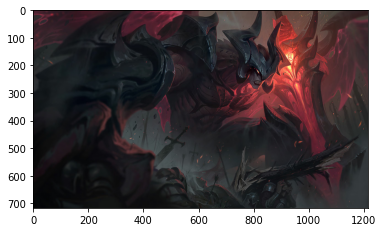

Valoracion general de Aatrox
positivos :  367
negativos :  133
------------------------
Si juegas a Aatrox te recomendamos:
> Segun skills: 
1 : Sion
2 : Sett
3 : Mordekaiser
4 : Renekton
5 : Swain
> Segun lore: 
1 : Varus
2 : Syndra
3 : Vel'Koz
4 : Kai'Sa
5 : Nasus
Interseccion:
[]
>Segun estilo:


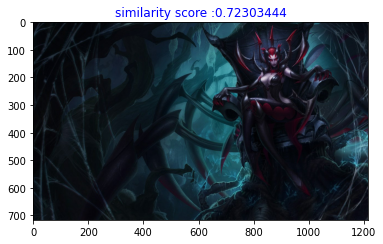

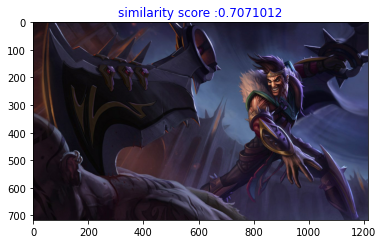

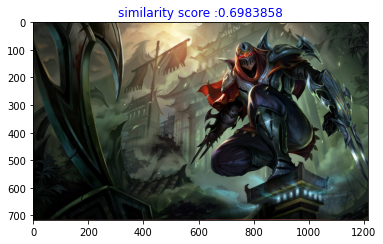

In [143]:
Leyenda = frontInfo.loc[frontInfo.name == campeon_picker.value,'id'].values.item()
show = loadImageURL('http://ddragon.leagueoflegends.com/cdn/img/champion/splash/'+Leyenda+'_0.jpg')
plt.imshow(show)
plt.show()
#----
tuits_leyenda = BuscarTweets(Leyenda,date_time)
#----
for t in tuits_leyenda:
  p = valorar_sentimientos(t)
  if p == 1:
    positivos = positivos + 1
  if p == 0:
    negativos = negativos + 1
print("Valoracion general de", campeon_picker.value)
print("positivos : "  ,positivos)
print("negativos : "  ,negativos)
print("------------------------")
print("Si juegas a",campeon_picker.value, "te recomendamos:")
recomendar(campeon_picker.value)
print(">Segun estilo:")
RecomendadorGrafico(Leyenda)

# FIN

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [146]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('PandasMyNewLegend.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'